##  Univariate time series forecasting test on PC4 5501 using XGBOOST


In [109]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
!pip install altair
import altair as alt

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import plot_importance, plot_tree


# show all columns in the dataframe
pd.set_option('max_columns', None)

In [110]:
os.getcwd()

'C:\\Users\\jcdek\\OneDrive\\Documents\\GitHub\\jads_enexis\\data\\processed'

In [294]:
# variables used in script
data_processed_location = '../data/processed'

if 'processed' not in os.getcwd():
    os.chdir(data_processed_location)

# kleinverbruikgegevens gegevens inlezen
df_nedu = pd.read_hdf('nedu_e2b.h5')


In [295]:
# Scale profile for better forecasts
df_nedu['y'] = df_nedu['y'] * 100000 

In [296]:
# Interactive zoom on both X and Y axis with two lower graphs.

interval = alt.selection_interval(encodings=['x'])
verbruik_range = alt.selection_interval(encodings=['y'])

base = alt.Chart(df_nedu.reset_index()).mark_line(clip=True).encode(
    x='ds:T',
    y='y:Q'
)

chart = base.encode(
    x=alt.X('ds:T', scale=alt.Scale(domain=interval.ref())),
    y=alt.Y('y:Q', scale=alt.Scale(domain=verbruik_range.ref()))
).properties(
    width=800,
    height=300
)

view = base.add_selection(
    interval
).properties(
    width=800,
    height=50,
)

window = base.add_selection(
    verbruik_range
).properties(
    width=800,
    height=100,
)

chart & view & window

alt.VConcatChart(...)

### Building Training/ Test Samples

In [311]:
# date where to split train and test
split_date = '31-Dec-2020'
# starting date of train dataset
from_date = '01-Jan-2019'

df_nedu_train = df_nedu.loc[(df_nedu['ds'] >= from_date) & (df_nedu['ds'] <= split_date) ].copy()
df_nedu_test = df_nedu.loc[df_nedu['ds'] > split_date].copy()
print (f'Length full     dataset: {len(df_nedu)} samples')
print (f'Length training dataset: {len(df_nedu_train)} samples')
print (f'Length test     dataset: {len(df_nedu_test)} samples')


Length full     dataset: 4383 samples
Length training dataset: 731 samples
Length test     dataset: 365 samples


### Feature engineering

In [312]:
# Create features from datetime index
def create_features(df, label=None):
    df['date'] = df['ds']
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','month', 'quarter', 'year', 'dayofyear','dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [313]:
# Create training and test datasets
X_train, y_train = create_features(df_nedu_train, label='y')
X_test, y_test = create_features(df_nedu_test, label='y')

<ipython-input-312-d8e2a45b3703>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


### Build XGBoost Model

In [314]:
reg = xgb.XGBRegressor(num_leaves=200, n_estimators=1000, subsample=1.0, min_child_weight=2, max_depth=25, learning_rate=0.05,
                       gamma=0, colsample_bytree=0.95)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose = False)

[21:19:46] WARNING: ..\src\learner.cc:541: 
Parameters: { num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.95, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=25,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_leaves=200, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1.0, tree_method='exact', validate_parameters=1,
             verbosity=None)

### Plot Feature Importances

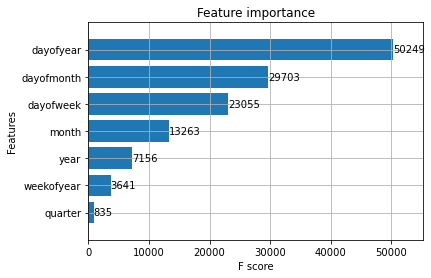

In [315]:
plot_importance(reg, height=0.8);

### Forecast on Test Set

In [316]:
df_nedu_test['Forecast'] = reg.predict(X_test)

In [317]:
df_nedu_all = pd.concat([df_nedu_test, df_nedu_train], sort = False)

In [318]:
# Interactive zoom on both X and Y axis with two lower graphs.

interval = alt.selection_interval(encodings=['x'])
verbruik_range = alt.selection_interval(encodings=['y'])

base = alt.Chart(df_nedu.reset_index()).mark_line(clip=True).encode(
    x='ds:T',
    y='y:Q'
)

forecast = alt.Chart(df_nedu_test.reset_index()).mark_line(clip=True).encode(
                     x='ds:T',
                     y='Forecast:Q'
                     )
    
chart = base.encode(
    x=alt.X('ds:T', scale=alt.Scale(domain=interval.ref())),
    y=alt.Y('y:Q', scale=alt.Scale(domain=verbruik_range.ref()))
).properties(
    width=800,
    height=400)

forecast_chart = forecast.encode(
    x=alt.X('ds:T', scale=alt.Scale(domain=interval.ref())),
    y=alt.Y('Forecast:Q', scale=alt.Scale(domain=verbruik_range.ref())),color=alt.value('red')
).properties(
    width=800,
    height=400)
    
view = base.add_selection(
    interval
).properties(
    width=800,
    height=50,
)

window = base.add_selection(
    verbruik_range
).properties(
    width=800,
    height=100,
)

chart + forecast_chart & view & window

alt.VConcatChart(...)

### Forecast into future

In [319]:
df_forecast_2022_2024 = pd.DataFrame(pd.date_range(start='1/1/2022', end='31/12/2024' , freq='D'), 
                                     columns=['ds']).sort_values(by='ds', ascending=True)
df_forecast_2022_2024['y'] = 0.0

In [320]:
# Create training and test datasets
X_forecast, _ = create_features(df_forecast_2022_2024, label='y')

<ipython-input-312-d8e2a45b3703>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [321]:
df_forecast_2022_2024['Forecast_future'] = reg.predict(X_forecast)

In [322]:
df_nedu = df_nedu[:-1]

In [323]:
# Interactive zoom on both X and Y axis with two lower graphs.

interval = alt.selection_interval(encodings=['x'])
verbruik_range = alt.selection_interval(encodings=['y'])

base = alt.Chart(df_nedu.reset_index()).mark_line(clip=True).encode(
    x='ds:T',
    y='y:Q'
)

forecast = alt.Chart(df_nedu_test.reset_index()).mark_line(clip=True).encode(
                     x='ds:T',
                     y='Forecast:Q'
                     )

forecast_future = alt.Chart(df_forecast_2022_2024.reset_index()).mark_line(clip=True).encode(
                     x='ds:T',
                     y='Forecast_future:Q'
                     )

chart = base.encode(
    x=alt.X('ds:T', scale=alt.Scale(domain=interval.ref())),
    y=alt.Y('y:Q', scale=alt.Scale(domain=verbruik_range.ref()))
).properties(
    width=800,
    height=400)

forecast_chart = forecast.encode(
    x=alt.X('ds:T', scale=alt.Scale(domain=interval.ref())),
    y=alt.Y('Forecast:Q', scale=alt.Scale(domain=verbruik_range.ref())),color=alt.value('red')
).properties(
    width=800,
    height=400)

forecast_future_chart = forecast_future.encode(
    x=alt.X('ds:T', scale=alt.Scale(domain=interval.ref())),
    y=alt.Y('Forecast_future:Q', scale=alt.Scale(domain=verbruik_range.ref())),color=alt.value('orange')
).properties(
    width=800,
    height=400)


view = base + forecast + forecast_future.add_selection(
    interval
).properties(
    width=800,
    height=50,
)

window = base + forecast + forecast_future.add_selection(
    verbruik_range
).properties(
    width=800,
    height=100,
)

chart + forecast_chart + forecast_future_chart & view & window

alt.VConcatChart(...)

### Evaluate the Performance

In [324]:
# The MAPE (Mean Absolute Percent Error) measures the size of the error
# in percentage terms.
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [325]:
# Make predictions using the training and testing set
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [326]:
print('R^2   train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('MSE   train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))

print('RMSE  train: %.2f, test: %.2f' %
      (np.sqrt(mean_squared_error(y_train, y_train_pred)),
       np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('MAE   train: %.2f, test: %.2f' %
      (mean_absolute_error(y_train, y_train_pred),
       mean_absolute_error(y_test, y_test_pred)))

print('MAPE  train: %.2f, test: %.2f' %
      (mean_absolute_percentage_error(y_train, y_train_pred),
       mean_absolute_percentage_error(y_test, y_test_pred)))

print(f'\nMean absolute percent accuracy: {100 - mean_absolute_percentage_error(y_test, y_test_pred):.2f}%')

R^2   train: 1.00, test: 0.95
MSE   train: 0.00, test: 64.09
RMSE  train: 0.01, test: 8.01
MAE   train: 0.00, test: 5.95
MAPE  train: 0.00, test: 2.23

Mean absolute percent accuracy: 97.77%


### RandomizedSearch Hyperparameter optimization

In [186]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
tscv = TimeSeriesSplit(n_splits=3)
param_dist = {
    "max_depth": [3, 4, 5, 10, 25],
    "learning_rate": [0.01, 0.05, 0.1, 0.15],
    "num_leaves": [50, 100, 200],
    "n_estimators": [100, 300, 500],
    'min_child_weight': [1, 2, 5],
    'gamma': [0, 0.1, 0.5, 1.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.9, 0.95, 1.0],
}
xgb_rgs = xgb.XGBRegressor(random_state=666)
xgb_gs = RandomizedSearchCV(xgb_rgs, 
                           n_jobs=6, 
                           n_iter=1000,
                           param_distributions=param_dist, 
                           cv = tscv, 
                           scoring="neg_mean_absolute_error", 
                           verbose=5, random_state=666)
xgb_gs.fit(X_train, y_train)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    5.3s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   13.0s


KeyboardInterrupt: 

In [57]:
xgb_gs.best_params_

{'subsample': 1.0,
 'num_leaves': 200,
 'n_estimators': 300,
 'min_child_weight': 2,
 'max_depth': 25,
 'learning_rate': 0.05,
 'gamma': 0,
 'colsample_bytree': 0.95}